### 實驗內容描述:
使用合成的資料和真實的資料去做未來數值的預測
###實驗結果:

* 合成資料
    * 多對多的時間預測
    * 多對一的時間預測
* 實際資料(股票預測)
    * 多對一的股價預測

###結果討論與實驗心得:
非常有趣，又學到一種處理資料並進行預測的方式




## 使用合成時間序列資料

### 生成各種函式的圖

**定義顯示圖表的function**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

def showPlot(x, y, label=None, x_label='t', y_label='x(t)',title=None,legend=False,xticks_num=10):
    #資料
    plt.plot(x, y, ".-",label=label)

    #網格
    plt.grid(True)

    #設定圖表標題
    if title:
        plt.title(title)

    #設定x, y軸標題
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)

    #畫一條水平線
    plt.hlines(y = 0, xmin = x[0], xmax = x[-1])

    #設定x,y軸上下限
    plt.xlim(x[0], x[-1])
    plt.ylim(-1.1, 1.1)

    #設定x軸顯示的刻度 plt.xticks(value, label)
    tick = np.linspace(0,x[-1],xticks_num)
    plt.xticks(tick ,['{:.02f}'.format(i) for i in tick])

    if legend:
        plt.legend()


**𝑠𝑖𝑛(𝑡)形狀的循環訊號**

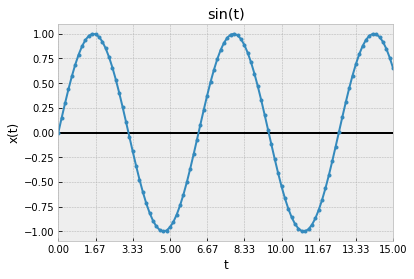

In [2]:
n_steps = 100
time = np.linspace(0, 15, n_steps) #在1秒內取樣100點
y = np.sin(time)

showPlot(time, y, title='sin(t)')

**𝑠𝑖𝑛(𝑡+10)形狀的循環訊號**

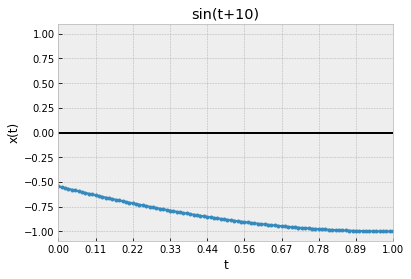

In [3]:
n_steps = 100
time = np.linspace(0, 1, n_steps) #在1秒內取樣100點
y = np.sin(time + 10) # 意即在第10 ~ 11秒取樣100點

showPlot(time, y, title='sin(t+10)')

**𝑎×𝑠𝑖𝑛(𝑏(𝑡+𝑐))形狀的循環訊號**


𝑎,𝑏,𝑐 分別會影響訊號的震幅、週期、時間軸平移

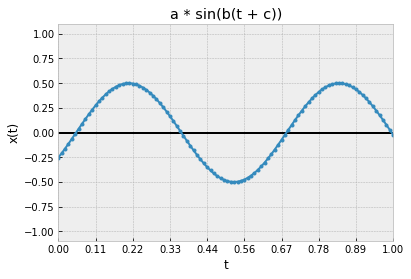

In [4]:
n_steps = 100
time = np.linspace(0, 1, n_steps) #在1秒內取樣100點
y = 0.5 * np.sin(10 * (time + 10))

showPlot(time, y, title='a * sin(b(t + c))')

**波形相加**

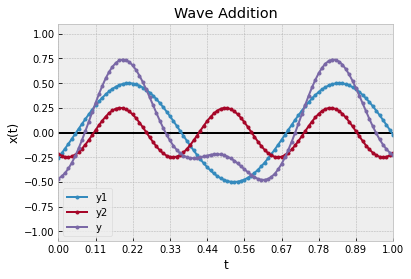

In [5]:
n_steps = 100
time = np.linspace(0, 1, n_steps) #在1秒內取樣100點
y1 = 0.5 * np.sin(10 * (time+10))
y2 = 0.25 * np.sin(20 * (time+20))
y = 0.5 * np.sin(10 * (time+10))+0.25 * np.sin(20 * (time+20))

showPlot(time, y1, title='Wave Addition',label = 'y1',legend=True)
showPlot(time, y2,label = 'y2',legend=True)
showPlot(time, y, label='y',legend=True)

**現實資料中通常含有雜訊**  

${\mathcal {N}}(\mu ,\sigma ^{2})$ = sigma * np.random.randn(...) + mu


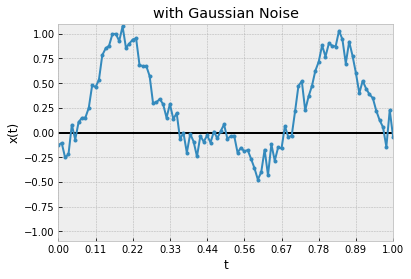

In [6]:
n_steps    = 100
time = np.linspace(0, 1, n_steps)
y = (0.1 * np.random.randn(n_steps) + 0.2) + (0.5 * np.sin(10 * (time + 10))) + (0.25 * np.sin(20 * (time + 20))) 

showPlot(time, y, title='with Gaussian Noise')

### 隨機時間序列資料生成

**定義樣本產生器** <br/>
隨機改變 0.5𝑠𝑖𝑛(10(𝑡+10)) 與 0.25𝑠𝑖𝑛(20(𝑡+20)) 的週期和時間軸位移，並在疊加後加上高斯雜訊${\mathcal {N}}$

In [7]:
def generate_samples(samples, n_steps):
    #確保每次的亂數ㄧ樣
    np.random.seed(9999)
    
    #np.random.randn(產生的shape)：產生Gaussian distribution的亂數
    freq1, freq2, offset1, offset2 = np.random.randn(4,samples,1)

    time = np.reshape(np.linspace(0,1,n_steps),(1,-1))

    y = 0.5 * np.sin((10 + 10 * freq1)*(time + offset1 + 10))+ \
        0.25 * np.sin((20+20*freq2) * (time + offset2 + 20))+\
        0.1 * np.random.rand(samples, n_steps) + 0.2
    
    return y[..., np.newaxis].astype(np.float32) #增維 => 之後方便建立資料集

**產生4個樣本** <br/>


samples.shape =  (4, 100, 1)


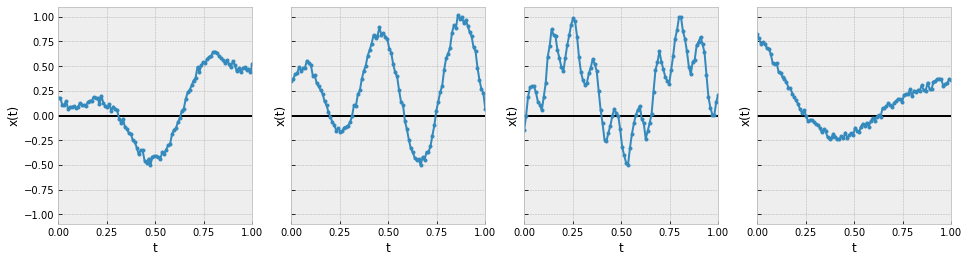

In [8]:
samples = generate_samples(4,100)

print('samples.shape = ',samples.shape)

fig, axes = plt.subplots(1, 4, sharey=True, figsize=(16,4)) #sharey 共用y軸

for idx,ax in enumerate(axes):
    plt.sca(ax) #set the current axes to be ax
    time = np.linspace(0,1,100)
    showPlot(time, samples[idx], xticks_num=5)

### 預測未來一個時間點的值：
用連續50個時間點資料來預測下個時間點的值

**評估指標**
+ mean squared error (MSE) = $\frac{1}{n}\sum_{i=1}^{n}(y\_true_{i}-y\_pred_{i})^{2}$
  + tf.keras.losses.MSE(y_true, y_pred)
+ mean absolute error (MAE) = $\frac{1}{n}\sum_{i=1}^{n}|y\_true_{i}-y\_pred_{i}|$
  + tf.keras.losses.MAE(y_true, y_pred)


#### 準備訓練、驗證、測試資料

In [9]:
import tensorflow as tf

n_steps = 50
samples = generate_samples(10000,n_steps + 1) #1 = 要訓練的值

#train:valid:test = 7:2:1
X_train = samples[:7000,:n_steps]
y_train = samples[:7000,-1]
X_valid = samples[7000:9000,:n_steps]
y_valid = samples[7000:9000,-1]
X_test  = samples[9000:,:n_steps]
y_test  = samples[9000:,-1]

print(samples.shape,X_train.shape,y_train.shape) #(幾筆資料, 幾天, 幾個attributes)

(10000, 51, 1) (7000, 50, 1) (7000, 1)


#### 呈現預測圖

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

def showPlot2(y, y_real, y_pred, length=50, n=1): 
    #前50個時間點的y
    plt.plot(y)
    
    #畫上第51個時間點 真正的值
    plt.plot([length - 1, length],[y[-1][0], y_real[0]],'-b')
    plt.plot(np.arange(length,length + n), y_real,'-bx',markersize=10, label='True')
    
    #畫上第51個時間點 預測的值
    plt.plot([length - 1, length],[y[-1][0], y_pred[0]],'#d62728')
    plt.plot(np.arange(length,length + n), y_pred,'-ro',markersize=5, label='Pred')

    plt.legend() 

#### 建立預測函數
會嘗試下面幾個預測函數
1. The last value 
2. Mean
3. Linear regression
4. Neural Network with one Dense layer
5. Neural Network with one SimpleRNN layer
6. Neural Network with three SimpleRNN layers 
7. Neural Network with three SimpleRNN layers and one dense layer



#### 不使用神經網路

##### **預測函數1:用前一時刻的值當作預測值**
$y_{i}=x_{i50}$

Mean Squared Error: 0.020201463
Mean Absolute Error: 0.111384496


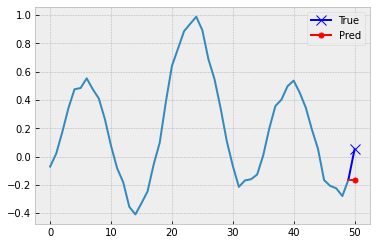

In [11]:
y_pred_1 = X_test[:,-1]

print('Mean Squared Error:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_1)).numpy())
print('Mean Absolute Error:',tf.reduce_mean(tf.keras.losses.MAE(y_test, y_pred_1)).numpy())

#呈現第一筆資料
showPlot2(X_test[0], y_test[0], y_pred_1[0])

##### **預測函數2:用平均值來預測下一時刻**
$y_{i} = \frac{1}{50}\sum_{j=1}^{50}x_{ij}$

Mean Squared Error: 0.15167174
Mean Absolute Error: 0.3281261


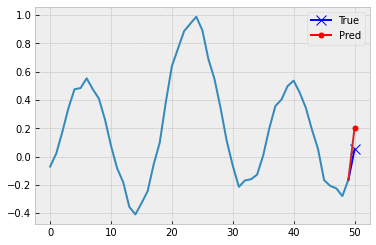

In [12]:
y_pred_2 = tf.reduce_mean(X_test, axis=1) #reduce_mean 取平均

print('Mean Squared Error:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_2)).numpy())
print('Mean Absolute Error:',tf.reduce_mean(tf.keras.losses.MAE(y_test, y_pred_2)).numpy())

#呈現第一筆資料
showPlot2(X_test[0], y_test[0], y_pred_2[0])

##### **預測函數3:線性迴歸**
$y_{i}=a_{1}x_{i1}+...+a_{50}x_{i50}+b\Rightarrow y_{i}=\begin{bmatrix}x_{i1},...,x_{i50},1\end{bmatrix}\begin{bmatrix} a_{1} \\ ... \\ a_{50} \\ b \end{bmatrix}\Rightarrow\mathbf{y}=\mathbf{X}\mathbf{a}$

Mean Squared Error: 0.008406538411198945
Mean Absolute Error: 0.0722857981224434


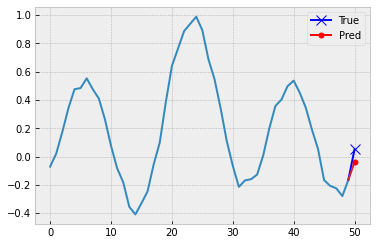

In [13]:
#將X變為上方形式
X = np.concatenate((X_train.squeeze(), np.ones((X_train.shape[0],1))), axis = 1)

#找到線性系統的最小平方解
a = np.linalg.lstsq(X, y_train.ravel(), rcond=None)[0]

#將X變為上方形式
test_X = np.concatenate((X_test.squeeze(), np.ones((X_test.shape[0],1))), axis = 1)

#將最佳解套用在X_test上
y_pred_3 = np.dot(test_X, a)[..., np.newaxis]

print('Mean Squared Error:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_3)).numpy())
print('Mean Absolute Error:',tf.reduce_mean(tf.keras.losses.MAE(y_test, y_pred_3)).numpy())
#呈現第一筆資料
showPlot2(X_test[0], y_test[0], y_pred_3[0])

#### 使用神經網路

檢視每Epoch的Loss

In [14]:
def showLoss(history, last_mse=False):
    plt.figure(figsize=(5,4))
    plt.plot(history.history['loss'],label='MSE')
    plt.plot(history.history['val_loss'],label='Valid_MSE')
    if last_mse:
        plt.plot(history.history['last_timestep_mse'],label='Last_Timestep_MSE')

    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.grid(True)
    plt.legend()
    plt.show()

##### **預測函數4:一層全連接層的類神經網路**

In [15]:
#建立model
model_fc = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(50,1)),
    tf.keras.layers.Flatten(), #Crucial
    tf.keras.layers.Dense(1)             
])

#設定optimizer和loss函數
model_fc.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
)

history_fc = model_fc.fit(X_train,  y_train,
                        batch_size=20,
                        validation_data=(X_valid,y_valid),
                        epochs=30,
                        verbose=1)

Epoch 1/30
350/350 [==============================] - 1s 2ms/step - loss: 0.1581 - val_loss: 0.0610
Epoch 2/30
350/350 [==============================] - 0s 1ms/step - loss: 0.0495 - val_loss: 0.0384
Epoch 3/30
350/350 [==============================] - 1s 2ms/step - loss: 0.0336 - val_loss: 0.0289
Epoch 4/30
350/350 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0233
Epoch 5/30
350/350 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0198
Epoch 6/30
350/350 [==============================] - 0s 1ms/step - loss: 0.0192 - val_loss: 0.0177
Epoch 7/30
350/350 [==============================] - 1s 1ms/step - loss: 0.0174 - val_loss: 0.0164
Epoch 8/30
350/350 [==============================] - 1s 1ms/step - loss: 0.0161 - val_loss: 0.0151
Epoch 9/30
350/350 [==============================] - 1s 1ms/step - loss: 0.0151 - val_loss: 0.0144
Epoch 10/30
350/350 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0138

檢視Loss並預測下一時間點

Mean Squared Error: 0.009299892
Mean Absolute Error: 0.07244618


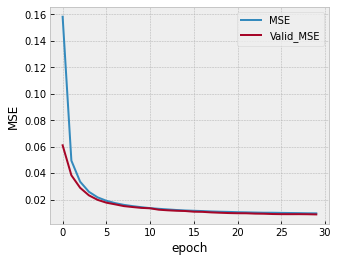

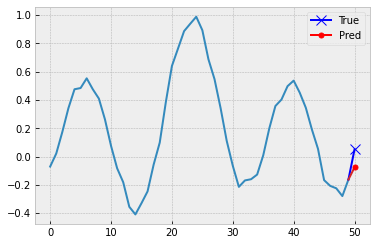

In [16]:
y_pred_4 = model_fc.predict(X_test)

print('Mean Squared Error:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_4)).numpy())
print('Mean Absolute Error:',tf.reduce_mean(tf.keras.losses.MAE(y_test, y_pred_4)).numpy())

showLoss(history_fc)
showPlot2(X_test[0], y_test[0], y_pred_4[0])

##### **預測函數5:簡單RNN**
下面顯示一個簡單的遞迴類神經單元，他會將上一個時刻的輸出$\mathbf{y}_{t-1}$匯回與這個時刻的輸入$\mathbf{x}_{t}$一起當作輸入。

SimpleRNN的激勵函數預設為tanh。若要嘗試GRU或LSTM，可置換SimpleRNN。

In [17]:
#建立model
model_rnn = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(1)            
])

#設定optimizer和loss函數
model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
)

history_rnn = model_rnn.fit(X_train,  y_train,
                        batch_size=20,
                        validation_data=(X_valid,y_valid),
                        epochs=30,
                        verbose=1)

Epoch 1/30
350/350 [==============================] - 4s 8ms/step - loss: 0.1863 - val_loss: 0.1143
Epoch 2/30
350/350 [==============================] - 2s 7ms/step - loss: 0.0712 - val_loss: 0.0443
Epoch 3/30
350/350 [==============================] - 2s 7ms/step - loss: 0.0397 - val_loss: 0.0348
Epoch 4/30
350/350 [==============================] - 2s 7ms/step - loss: 0.0343 - val_loss: 0.0311
Epoch 5/30
350/350 [==============================] - 2s 7ms/step - loss: 0.0307 - val_loss: 0.0278
Epoch 6/30
350/350 [==============================] - 2s 7ms/step - loss: 0.0276 - val_loss: 0.0251
Epoch 7/30
350/350 [==============================] - 2s 7ms/step - loss: 0.0250 - val_loss: 0.0227
Epoch 8/30
350/350 [==============================] - 2s 7ms/step - loss: 0.0228 - val_loss: 0.0207
Epoch 9/30
350/350 [==============================] - 2s 7ms/step - loss: 0.0209 - val_loss: 0.0190
Epoch 10/30
350/350 [==============================] - 2s 7ms/step - loss: 0.0192 - val_loss: 0.0176

檢視Loss並預測下一時間點

Mean Squared Error: 0.012745333
Mean Absolute Error: 0.09064924


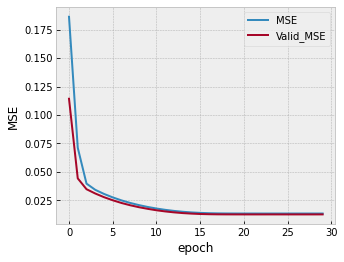

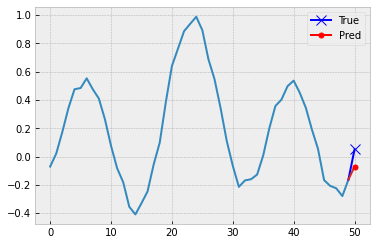

In [18]:
y_pred_5 = model_rnn.predict(X_test)

print('Mean Squared Error:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_5)).numpy())
print('Mean Absolute Error:',tf.reduce_mean(tf.keras.losses.MAE(y_test, y_pred_5)).numpy())

showLoss(history_rnn)
showPlot2(X_test[0], y_test[0], y_pred_5[0])

##### **預測函數6:多堆疊幾層SimpleRNN**
+ SimpleRNN之return_sequences設成True，將每個時間點的輸出都會給下一層，不然只會有最後一個時間點的輸出。舉例，若輸入是50個時間點，那麼下面的輸出shape會是(50,20)。若return_sequences設成False，那麼輸出為(20,)


         tf.keras.layers.SimpleRNN(20, return_sequences=True)

In [19]:
#建立model
model_mrnn = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(15, return_sequences=True),
    tf.keras.layers.SimpleRNN(15, return_sequences=True),
    tf.keras.layers.SimpleRNN(1) 
])

#設定optimizer和loss函數
model_mrnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
)

history_mrnn = model_mrnn.fit(X_train,  y_train,
                        batch_size=20,
                        validation_data=(X_valid,y_valid),
                        epochs=30,
                        verbose=1)

Epoch 1/30
350/350 [==============================] - 11s 26ms/step - loss: 0.0275 - val_loss: 0.0105
Epoch 2/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 3/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0104 - val_loss: 0.0094
Epoch 4/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0099 - val_loss: 0.0087
Epoch 5/30
350/350 [==============================] - 9s 26ms/step - loss: 0.0096 - val_loss: 0.0087
Epoch 6/30
350/350 [==============================] - 10s 28ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 7/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 8/30
350/350 [==============================] - 9s 26ms/step - loss: 0.0086 - val_loss: 0.0075
Epoch 9/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0081 - val_loss: 0.0072
Epoch 10/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0073 - val_

檢視Loss並預測下一時間點

Mean Squared Error: 0.004879214
Mean Absolute Error: 0.05544322


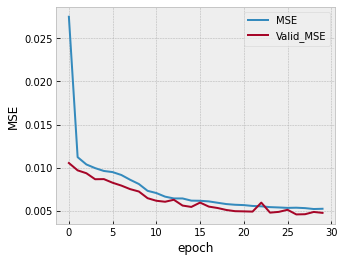

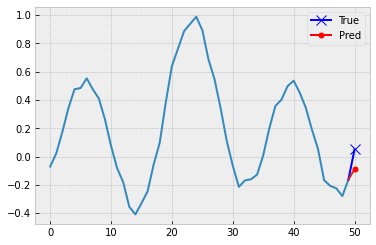

In [20]:
y_pred_6 = model_mrnn.predict(X_test)

print('Mean Squared Error:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_6)).numpy())
print('Mean Absolute Error:',tf.reduce_mean(tf.keras.losses.MAE(y_test, y_pred_6)).numpy())

showLoss(history_mrnn)
showPlot2(X_test[0], y_test[0], y_pred_6[0])

由於model_mrnn沒限制每一段序列長度。我們來比較看看，50時間點、40時間點、30時間點、20時間點、10時間點的預測準確度。看來約最近的30時間點來預測就夠了。

In [21]:
#X_train[:,0:].shape = (7000,50,1) 

for n_steps in [50,40,30,20,10]:
    y_p = model_mrnn.predict(X_train[:,50-n_steps:])
    tr_mse = tf.reduce_mean(tf.keras.losses.MSE(y_train, y_p)).numpy()
    y_p = model_mrnn.predict(X_test[:,50-n_steps:])
    te_mse = tf.reduce_mean(tf.keras.losses.MSE(y_test, y_p)).numpy()
    print('MSE (n_steps:{}):train {:.4f} test {:.4f}'.format(n_steps,tr_mse,te_mse))

MSE (n_steps:50):train 0.0050 test 0.0049
MSE (n_steps:40):train 0.0050 test 0.0049
MSE (n_steps:30):train 0.0053 test 0.0051
MSE (n_steps:20):train 0.0078 test 0.0075
MSE (n_steps:10):train 0.0262 test 0.0246


##### **預測函數7:改變輸出層為全連接層**

In [22]:
import tensorflow as tf

#建立model
model_drnn = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(15, return_sequences=True),
    tf.keras.layers.SimpleRNN(15, return_sequences=True),
    tf.keras.layers.SimpleRNN(15),
    tf.keras.layers.Dense(1)
])

#設定optimizer和loss函數
model_drnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
)

history_drnn = model_drnn.fit(X_train,  y_train,
                        batch_size=20,
                        validation_data=(X_valid,y_valid),
                        epochs=30,
                        verbose=1)

Epoch 1/30
350/350 [==============================] - 11s 26ms/step - loss: 0.0392 - val_loss: 0.0149
Epoch 2/30
350/350 [==============================] - 9s 26ms/step - loss: 0.0115 - val_loss: 0.0089
Epoch 3/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 4/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0083 - val_loss: 0.0075
Epoch 5/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 6/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 7/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 8/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0074 - val_loss: 0.0062
Epoch 9/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 10/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0067 - val_l

檢視Loss並預測下一時間點

Mean Squared Error: 0.0046943272
Mean Absolute Error: 0.05404378


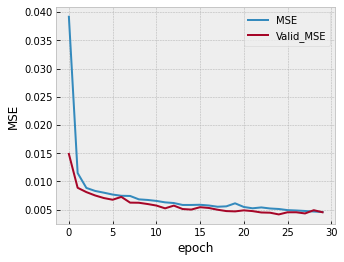

(50, 1) (1,) (1,)


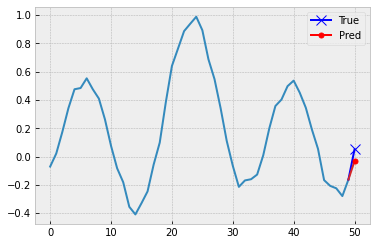

In [23]:
y_pred_7 = model_drnn.predict(X_test)

print('Mean Squared Error:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_7)).numpy())
print('Mean Absolute Error:',tf.reduce_mean(tf.keras.losses.MAE(y_test, y_pred_7)).numpy())

showLoss(history_drnn)
showPlot2(X_test[0], y_test[0], y_pred_7[0])
print(X_test[0].shape,y_test[0].shape,y_pred_7[0].shape)

#### 比較7個預測函數


In [24]:
preds = [y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_pred_5, y_pred_6, y_pred_7]
names = ['The last value', 'Average', 'Linear Regression', 'Full Connected', 'SimpleRNN','3RNN', '3RNN/Dense']

for y_pred, name in zip(preds, names):
    print('Method: {:<20s} MSE:{:.4f}'.format(name,tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred)).numpy()))

Method: The last value       MSE:0.0202
Method: Average              MSE:0.1517
Method: Linear Regression    MSE:0.0084
Method: Full Connected       MSE:0.0093
Method: SimpleRNN            MSE:0.0127
Method: 3RNN                 MSE:0.0049
Method: 3RNN/Dense           MSE:0.0047


### 預測多個時間點
假設往前預測5個時間點的值。
+ 方法1:在不修改上面模型的狀況下，可以將預測的下個時間點當作資料，與原本資料串接後，用來預測下下個時刻。以此類推可以往前預測多個時間點。

+ 方法2:直接擴充輸出層輸出單元數，訓練一次可以預測多個未來時間點的模型。

+ 方法3:建立遞迴類神經網路，訓練他在第$x_{i1}$時間點輸出$x_{i2},...,x_{i6}$,在第二時間點$x_{i2}$輸出$x_{i3},...,x_{i7}$，...,在第50時間點輸出$x_{i51},...,x_{i55}$。對一個測試序列，取最後一時間點的輸出為預測結果。

#### 方法一

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


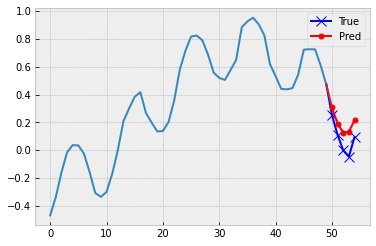

In [25]:
n_steps = 50
sample = generate_samples(1,n_steps+5)
X_1 = sample[:,:n_steps]

#用預測的下個時間點做為資料
for _ in range(5):
    y_pred_m1 = model_drnn.predict(X_1)
    X_1 = np.concatenate((X_1.reshape(1,-1), y_pred_m1),axis=1)[..., np.newaxis]

showPlot2(sample[0,:n_steps], sample[0,n_steps:], X_1[0,-5:], n=5)

#### 方法二

準備資料集

In [26]:
n_steps = 50
samples2 = generate_samples(10000,n_steps+5)

X_train2 = samples2[:7000,:n_steps]
y_train2 = samples2[:7000,n_steps:,0]
X_valid2 = samples2[7000:9000,:n_steps]
y_valid2 = samples2[7000:9000,n_steps:,0]
X_test2  = samples2[9000:,:n_steps]
y_test2  = samples2[9000:,n_steps:,0]

建立model並訓練

In [27]:
import tensorflow as tf

#建立model
model_Mdrnn = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(15, return_sequences=True),
    tf.keras.layers.SimpleRNN(15, return_sequences=True),
    tf.keras.layers.SimpleRNN(15),
    tf.keras.layers.Dense(5)
])

#設定optimizer和loss函數
model_Mdrnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
)

history_Mdrnn = model_Mdrnn.fit(X_train2,  y_train2,
                        batch_size=20,
                        validation_data=(X_valid2,y_valid2),
                        epochs=30,
                        verbose=1)

Epoch 1/30
350/350 [==============================] - 12s 26ms/step - loss: 0.1176 - val_loss: 0.0821
Epoch 2/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0699 - val_loss: 0.0614
Epoch 3/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0609 - val_loss: 0.0582
Epoch 4/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0584 - val_loss: 0.0545
Epoch 5/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0556 - val_loss: 0.0501
Epoch 6/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0531 - val_loss: 0.0518
Epoch 7/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0526 - val_loss: 0.0480
Epoch 8/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0488 - val_loss: 0.0436
Epoch 9/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0475 - val_loss: 0.0450
Epoch 10/30
350/350 [==============================] - 9s 25ms/step - loss: 0.0467 - val_l

檢視Loss並預測下一時間點

Mean Squared Error: 0.025582604
Mean Absolute Error: 0.11680213


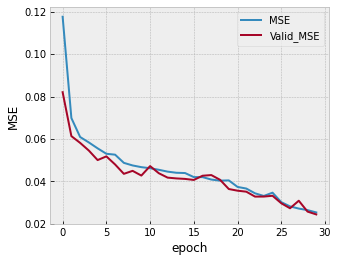

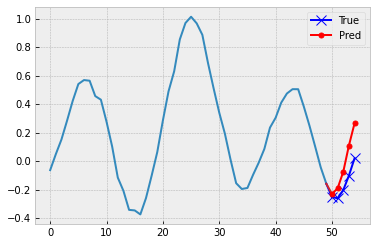

In [28]:
y_pred_m2 = model_Mdrnn.predict(X_test2)

print('Mean Squared Error:',tf.reduce_mean(tf.keras.losses.MSE(y_test2, y_pred_m2)).numpy())
print('Mean Absolute Error:',tf.reduce_mean(tf.keras.losses.MAE(y_test2, y_pred_m2)).numpy())

showLoss(history_Mdrnn)
showPlot2(X_test2[0], y_test2[0], y_pred_m2[0], n=5)

#### 方法三

準備資料集

In [49]:
n_steps  = 50
samples3 = generate_samples(10000, n_steps + 5)
X_train3 = samples3[:7000, :n_steps]
X_valid3 = samples3[7000:9000, :n_steps]
X_test3  = samples3[9000:, :n_steps]

# X1時間點輸出 X2,...,X6
y = np.empty((10000, n_steps, 5))
y_train3 = y[:7000,:]
y_valid3 = y[7000:9000,:]
y_test3  = y[9000:,:]

(7000, 50, 1) (10000, 50, 5) (7000, 50, 5) (2000, 50, 5) (1000, 50, 5)


建立model

In [30]:
mp_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(15, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(15, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5))
])
mp_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, None, 15)          255       
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, None, 15)          465       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 5)           80        
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________


In [31]:
def last_timestep_mse(y_true, y_pred):
    return tf.keras.metrics.mean_squared_error(y_true[:, -1], y_pred[:, -1])

mp_model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=[last_timestep_mse])
history = mp_model.fit(X_train3, y_train3, epochs=20,validation_data=(X_valid3, y_valid3))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


219/219 [==============================] - 6s 20ms/step - loss: 0.0774 - last_timestep_mse: 0.0748 - val_loss: 0.0662 - val_last_timestep_mse: 0.0607
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0590 - last_timestep_mse: 0.0542 - val_loss: 0.0489 - val_last_timestep_mse: 0.0424
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0456 - last_timestep_mse: 0.0386 - val_loss: 0.0407 - val_last_timestep_mse: 0.0326
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0390 - last_timestep_mse: 0.0302 - val_loss: 0.0369 - val_last_timestep_mse: 0.0278
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0364 - last_timestep_mse: 0.0278 - val_loss: 0.0344 - val_last_timestep_mse: 0.0263
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0340 - last_timestep_mse: 0.0249 - val_loss: 0.0326 - val_last_timestep_mse: 0.0231
Epoch 7/20
219/219 [=========================

檢視Loss並預測下一時間點

Mean Squared Error: 0.017514182337928404
Mean Absolute Error: 0.09716234699455091


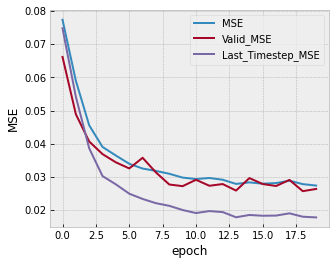

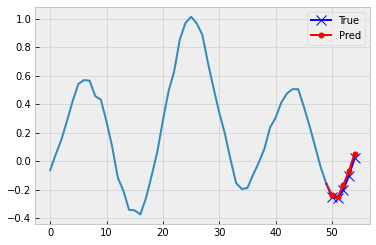

In [32]:
y_pred_mpt_3 = mp_model.predict(X_test3)[:,-1]
 
print('Mean Squared Error:',tf.reduce_mean(tf.keras.losses.MSE(y_pred_mpt_3,y_test3[:,-1,:])).numpy())
print('Mean Absolute Error:',tf.reduce_mean(tf.keras.losses.MAE(y_pred_mpt_3,y_test3[:,-1,:])).numpy())

showLoss(history,last_mse=True)
showPlot2(X_test3[0],y_test3[0,-1],y_pred_mpt_3[0], n=5) 

## 實際資料：Google Stock Prediction

### 建立資料集

#### 搜尋並下載資料集

**Kaggle**

In [ ]:
api_token = {"username":"littlehongman","key":"8fbc4bedc0519be58e56f59fe436cc32"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')

#找Avengers的資料集
!kaggle datasets list -s Google-Stock-Prediction

ref                                                           title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
shreenidhihipparagi/google-stock-prediction                   Google Stock Prediction                              29KB  2021-04-12 12:53:13            619  
rohanrao/nifty50-stock-market-data                            NIFTY-50 Stock Market Data (2000 - 2021)             18MB  2021-05-01 09:23:17          12550  
camnugent/sandp500                                            S&P 500 stock data                                   19MB  2018-02-10 03:15:53          39602  
rahulsah06/gooogle-stock-price                                Gooogle Stock Price                                  23KB  2019-10-22 12:12:50            573  
yash612/stockmarket-sentiment-dataset               

In [ ]:
if not os.path.exists('shreenidhihipparagi/google-stock-prediction'):
    !kaggle datasets download shreenidhihipparagi/google-stock-prediction 

  0% 0.00/29.1k [00:00<?, ?B/s]
100% 29.1k/29.1k [00:00<00:00, 47.5MB/s]


**解壓縮並分拆資料集**

In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/google-stock-prediction.zip',compression='zip')

#移除不重要的attribute和日期
df = df.drop(columns=['symbol','divCash','splitFactor','adjHigh','adjLow','adjOpen','adjVolume'])

#將日期轉成datatime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df.head()

,date,close,high,low,open,volume,adjClose
0,2016-02-16 00:00:00+00:00,691.00,698.0000,685.05,692.98,2520021,691.00
1,2016-02-17 00:00:00+00:00,708.40,709.7500,691.38,699.00,2492634,708.40
2,2016-02-18 00:00:00+00:00,697.35,712.3500,696.03,710.00,1883248,697.35
3,2016-02-19 00:00:00+00:00,700.91,703.0805,694.05,695.03,1589281,700.91
4,2016-02-22 00:00:00+00:00,706.46,713.2400,702.51,707.45,1949816,706.46


#### 標準化及正規化

**Z分數標準化(Z-Score Standardization)**

In [ ]:
from sklearn.preprocessing import StandardScaler

def standardize(x):
    scaler = StandardScaler()
    return scaler.fit_transform(x)

**最小值最大值正規化(Min-Max Normalization)**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalize(x):
    scaler = MinMaxScaler( feature_range=(0,1) ) # 設定縮放的區間上下限
    return scaler.fit_transform(x)

####建立訓練集
根據過去天數和未來天數可以建立下列模型
<br/>
<img src="https://imgur.com/MCj0oaM.png" width="400"/>


In [ ]:
import numpy as np

def buildData(data, pastDay=30, futureDay=1): 
    X, y = [], []
    for i in range(data.shape[0] - futureDay - pastDay + 1):
        X.append(np.array(data[i : i+pastDay]))
        y.append(np.array(data[i + pastDay:i + pastDay + futureDay][:,5])) #AdjClose

    return np.array(X), np.array(y)[...,np.newaxis]

#### 資料擴充

In [ ]:
def augFeatures(data):
    #插入新feature
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek

    #非數值要移除
    data = data.drop(columns=['date']) 

    return data

#### 資料分拆


In [ ]:
from sklearn.model_selection import train_test_split

def splitData(X, y): #train:val:test = 0.85:0.15
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
    return X_train, y_train, X_val, y_val

#### 完整流程

In [ ]:
#擴增feature
data = augFeatures(df)

#正規化
data_norm = normalize(data)

#根據過去30天預測隔天
X, y = buildData(data_norm)

#分拆資料並shuffle
X_train, y_train, X_val, y_val = splitData(X, y)

### 建立模型並訓練

#### 使用Early Stopping

In [ ]:
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

#### 建立多對一的LSTM模型

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanSquaredError(),
    )

    return model

#### 開始訓練

In [ ]:
model = create_model()
history = model.fit(X_train, y_train,
                    batch_size=32,
                    validation_data=(X_val,y_val),
                    epochs=1000,
                    callbacks=[callback],
                    verbose=1)

Epoch 1/1000
33/33 [==============================] - 3s 24ms/step - loss: 0.0425 - val_loss: 0.0086
Epoch 2/1000
33/33 [==============================] - 0s 12ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 3/1000
33/33 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 4/1000
33/33 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 9.5372e-04
Epoch 5/1000
33/33 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 8.5557e-04
Epoch 6/1000
33/33 [==============================] - 0s 12ms/step - loss: 9.2422e-04 - val_loss: 7.3270e-04
Epoch 7/1000
33/33 [==============================] - 0s 12ms/step - loss: 7.9308e-04 - val_loss: 7.2390e-04
Epoch 8/1000
33/33 [==============================] - 0s 12ms/step - loss: 7.3004e-04 - val_loss: 6.4093e-04
Epoch 9/1000
33/33 [==============================] - 0s 12ms/step - loss: 6.5374e-04 - val_loss: 7.3523e-04
Epoch 10/1000
33/33 [==============================

#### 檢視loss變化

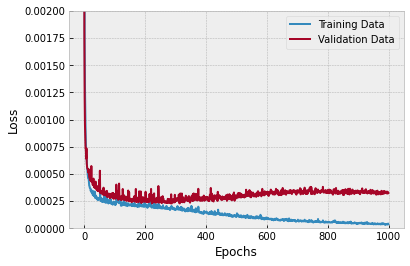

In [ ]:
plt.plot(history.history['loss'], label='Training Data')
plt.plot(history.history['val_loss'], label='Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.002)
plt.legend()

### 測試模型

#### 下載最新資料 <br/>
使用fake agent抓取資料

In [ ]:
fakeAgent = "User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:32.0) Gecko/20100101Firefox/32.0"

!wget --user-agent=fakeAgent 'https://query1.finance.yahoo.com/v7/finance/download/GOOG?period1=1591603313&period2=1623139313&interval=1d&events=history&includeAdjustedClose=true' -O 'GOOG.csv'

--2021-06-08 16:00:00--  https://query1.finance.yahoo.com/v7/finance/download/GOOG?period1=1591603313&period2=1623139313&interval=1d&events=history&includeAdjustedClose=true
Resolving query1.finance.yahoo.com (query1.finance.yahoo.com)... 119.161.16.12, 119.161.14.17, 119.161.16.11, ...
Connecting to query1.finance.yahoo.com (query1.finance.yahoo.com)|119.161.16.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘GOOG.csv’

GOOG.csv                [ <=>                ]  19.47K  --.-KB/s    in 0.05s   

2021-06-08 16:00:01 (394 KB/s) - ‘GOOG.csv’ saved [19934]



#### 檢視資料

In [ ]:
import pandas as pd

df1 = pd.read_csv('GOOG.csv')
df1.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
247,2021-06-01,2422.000000,2437.970947,2404.879883,2429.810059,2429.810059,958300
248,2021-06-02,2435.310059,2442.000000,2404.199951,2421.280029,2421.280029,857900
249,2021-06-03,2395.020020,2409.745117,2382.830078,2404.610107,2404.610107,917300
250,2021-06-04,2422.520020,2453.858887,2417.770020,2451.760010,2451.760010,1295800
251,2021-06-07,2451.320068,2468.000000,2441.072998,2466.090088,2466.090088,1189600


#### 將資料轉成訓練資料的格式

In [ ]:
#依訓練資料排序column
df1 = df1[['Date','Close','High','Low','Open','Volume','Adj Close']]

#將日期轉成datatime
df1['Date'] = pd.to_datetime(df1['Date'], errors='coerce')

df1 = df1.rename(columns={'Date': 'date'})

#記住日期，用以呈現於圖表
dates = df1['date']

#### Normalization 和 Inverse

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalize(x):
    scaler = MinMaxScaler() # 設定縮放的區間上下限
    y = scaler.fit_transform(x)
    return y, scaler.min_[5], scaler.scale_[5]

def denormalize(min, scale, y):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.min_, scaler.scale_ = min, scale
    
    return scaler.inverse_transform(y)

#### 預測資料
記下normalization的參數

In [ ]:
#擴增columns
real_stock = augFeatures(df1)

#正規化
real_stock_norm, min, scale = normalize(real_stock)

#建立資料
real_stock_norm_X, real_stock_norm_y = buildData(real_stock_norm)

#預測
predict_stock_norm = model.predict(real_stock_norm_X)

#### 還原原始數值

In [ ]:
real_stock_y = denormalize(min, scale, real_stock_norm_y.reshape(-1,1))
predict_stock_y = denormalize(min, scale, predict_stock_norm.reshape(-1,1))

#### 評估成效

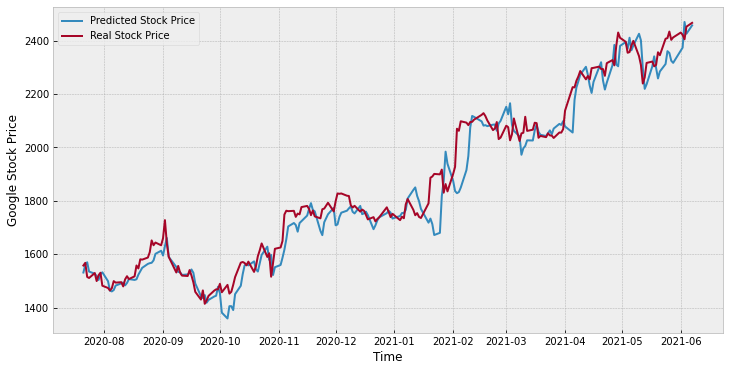

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(dates[30:],predict_stock_y, label = 'Predicted Stock Price')
plt.plot(dates[30:],real_stock_y, label = 'Real Stock Price')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()